In [0]:
!pip3 install mlflow
!pip install scikit-learn
!pip install flaml
!pip install "flaml[automl]"
!pip install flaml[automl]
%pip install flaml[automl] matplotlib openml
!pip install evidently
!pip install torch
!pip install --upgrade typing_extensions
%pip show flaml


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
import mlflow.pyfunc
from mlflow.models.signature import infer_signature
from flaml import AutoML
from sklearn.metrics import fbeta_score, f1_score, recall_score, precision_score, make_scorer, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from mlflow.tracking import MlflowClient
from mlflow.models.signature import infer_signature
import requests
import json
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset
from evidently import ColumnMapping
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
import torch
from evidently.ui.workspace.cloud import CloudWorkspace
from evidently.ui.dashboards import DashboardPanelPlot, ReportFilter, PanelValue, TestFilter, TestSuitePanelType, DashboardPanelTestSuite, PlotType
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [0]:
# Define input parameters for the notebook
dbutils.widgets.text("data_csv", "")  # For the CSV file path
data_csv = dbutils.widgets.get("data_csv")
print(f"Data CSV Path: {data_csv}")

Data CSV Path: 


In [0]:
df = pd.read_csv("/Workspace/Users/liu20@uchicago.edu/diabetes.csv")
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


#### EDA

In [0]:
df.shape

(70692, 22)

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [0]:
df["Diabetes_binary"].value_counts()

0.0    35346
1.0    35346
Name: Diabetes_binary, dtype: int64

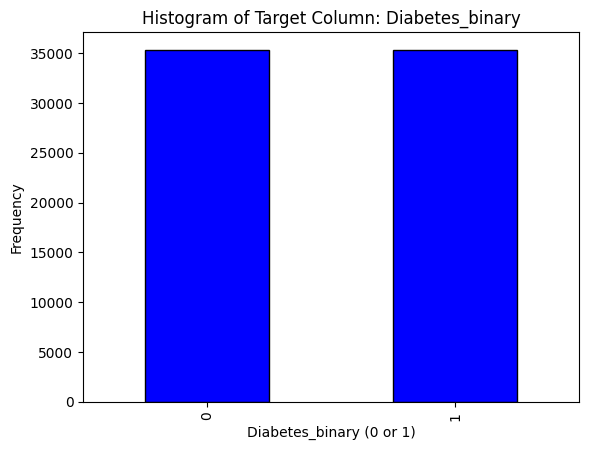

In [0]:
counts = df['Diabetes_binary'].astype(int).value_counts().sort_index()

counts.plot(kind='bar', color='blue', edgecolor='black')

plt.xlabel('Diabetes_binary (0 or 1)')
plt.ylabel('Frequency')
plt.title('Histogram of Target Column: Diabetes_binary')
plt.xticks([0, 1])  

plt.show()

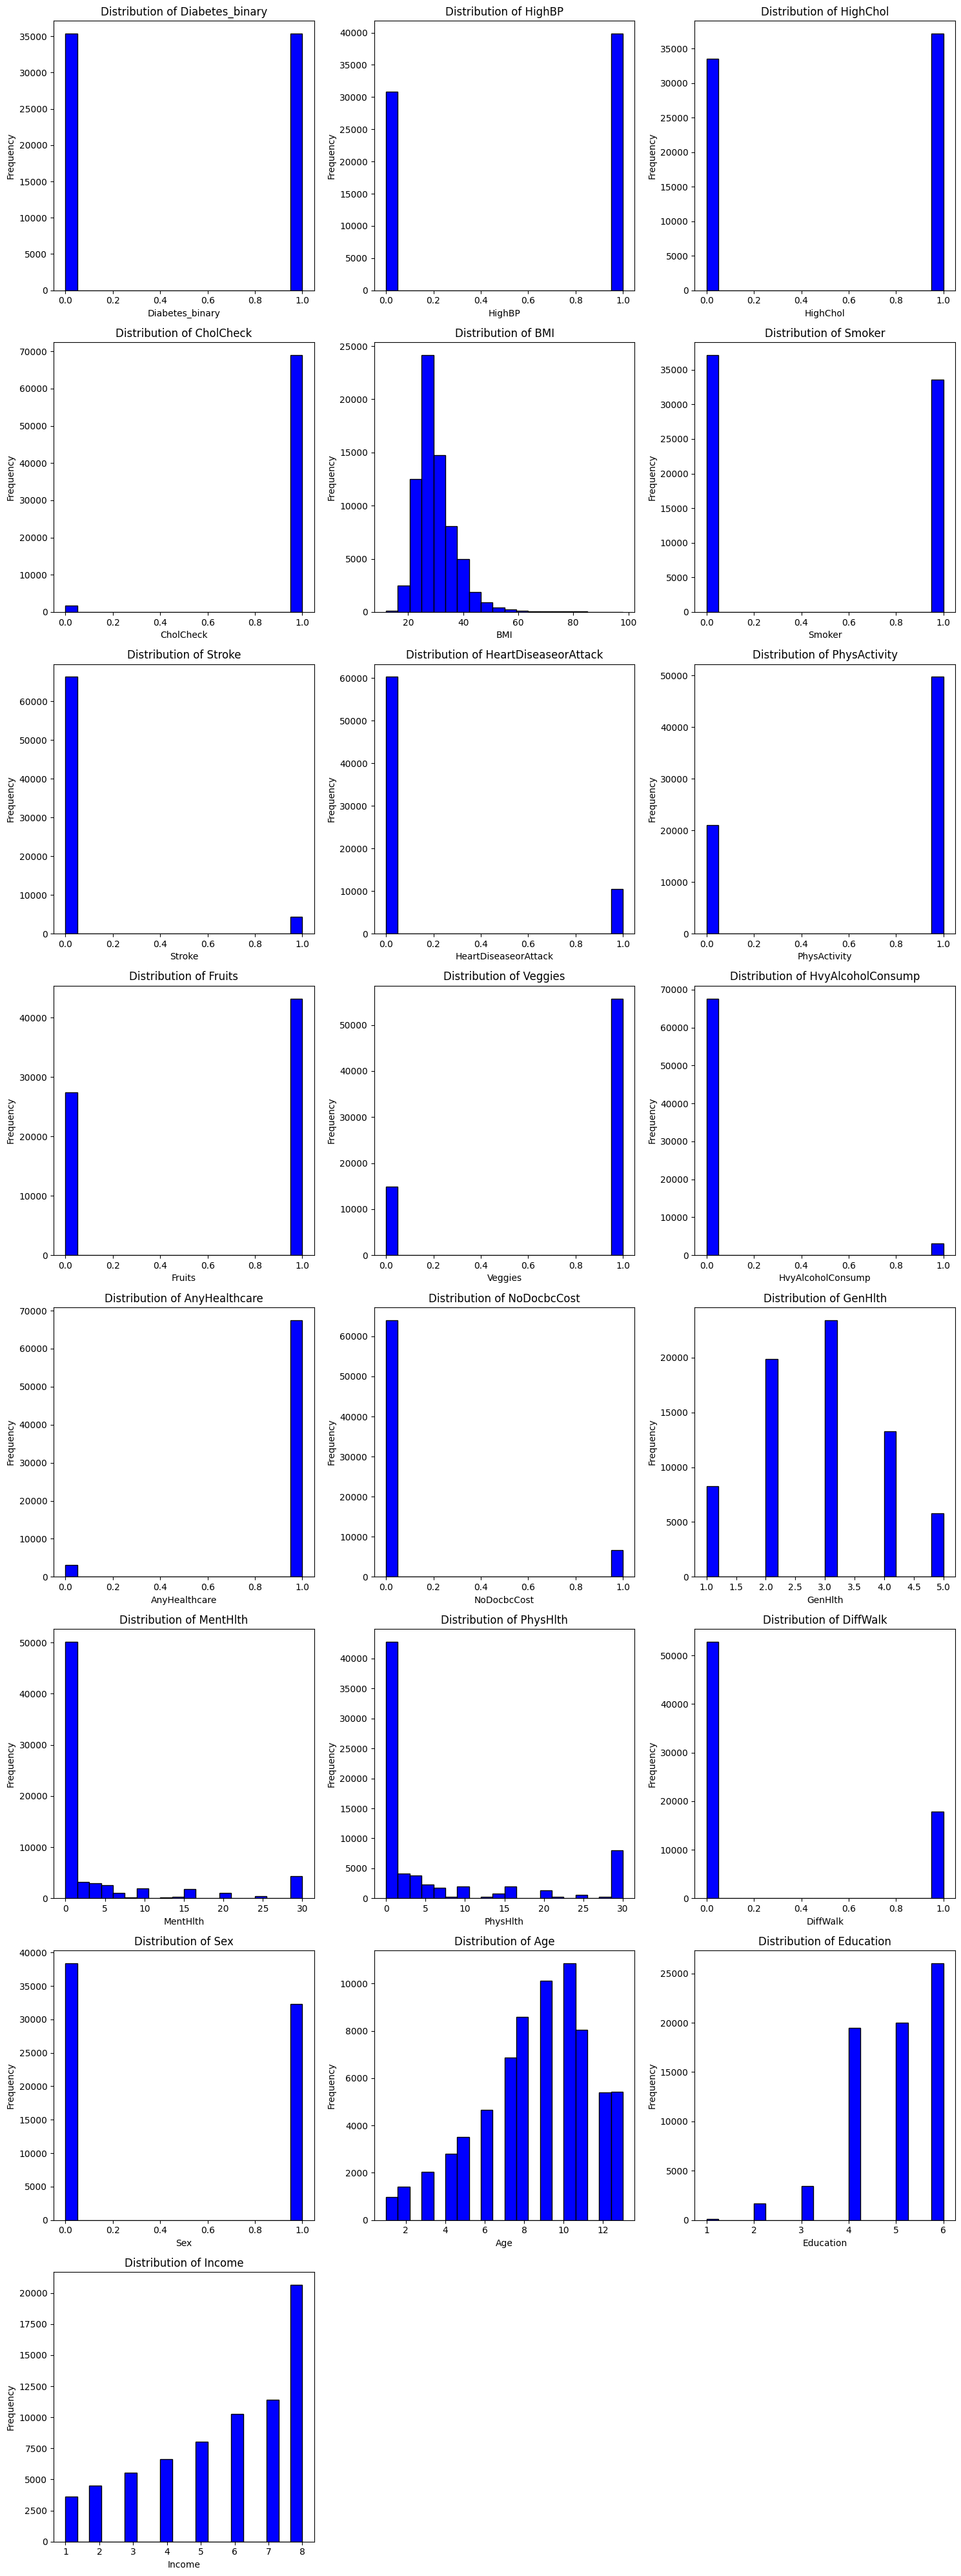

In [0]:
numeric_columns = df.select_dtypes(include=['number']).columns

# Create subplots
n_cols = 3  # Number of columns in the grid
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the axes for easy iteration

for i, column in enumerate(numeric_columns):
    axes[i].hist(df[column], bins=20, color='blue', edgecolor='black')
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


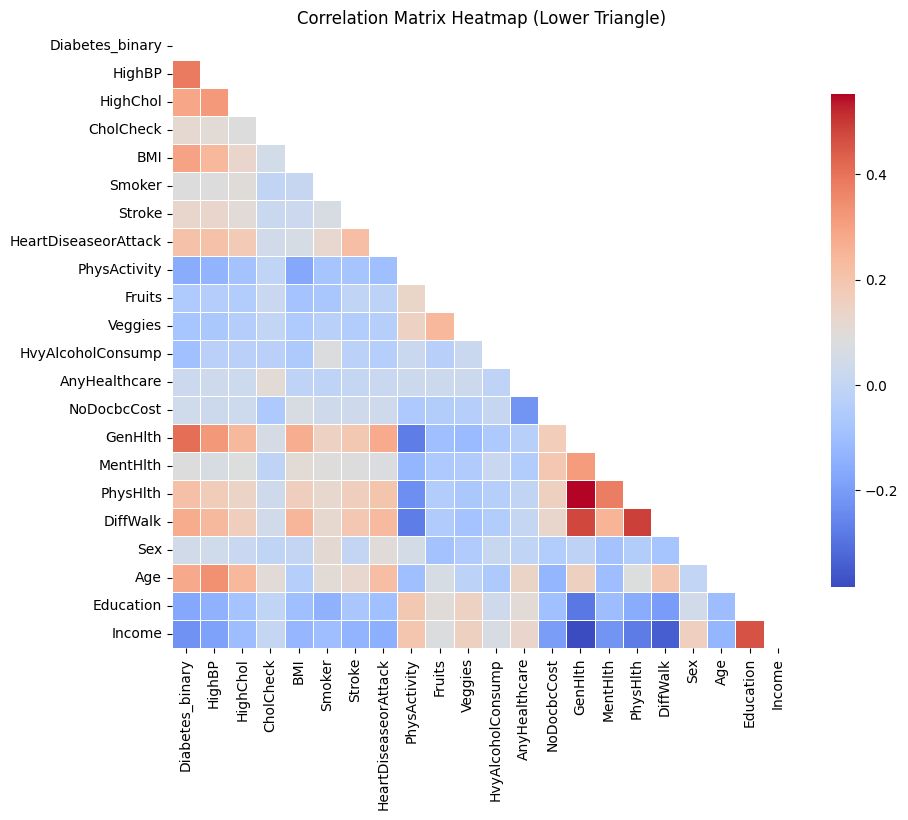

In [0]:
correlation_matrix = df.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

sns.heatmap(
    correlation_matrix, 
    mask=mask, 
    cmap='coolwarm',  # Color map
    fmt='.2f',  # Format the annotation to 2 decimal places
    linewidths=0.5,  # Add lines between squares
    cbar_kws={'shrink': 0.8}  # Shrink the color bar
)

plt.title('Correlation Matrix Heatmap (Lower Triangle)')
plt.show()


#### Train/test split with stratify technique

In [0]:
X = df.drop(columns=['Diabetes_binary'])  
y = df['Diabetes_binary']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.1,  # 10% for test
    stratify=y,     # Stratify by the target variable
    random_state=42 # Ensure reproducibility
)

train_df = X_train.copy()
train_df['Diabetes_binary'] = y_train

test_df = X_test.copy()
test_df['Diabetes_binary'] = y_test

# Check class balance in train and test sets
print("Train class distribution:\n", train_df['Diabetes_binary'].value_counts(normalize=True))
print("Test class distribution:\n", test_df['Diabetes_binary'].value_counts(normalize=True))

Train class distribution:
 0.0    0.5
1.0    0.5
Name: Diabetes_binary, dtype: float64
Test class distribution:
 1.0    0.5
0.0    0.5
Name: Diabetes_binary, dtype: float64


#### Set up MLFlow & use FLAML for initial model selection

In [0]:
# Set up MLflow experiment
mlflow.set_experiment("/Users/liu20@uchicago.edu/Diabetes_Prediction_Refinement")

# Step 1: Use FLAML to narrow down algorithm choices
print("Running FLAML for initial model selection...")
automl = AutoML()
automl_settings = {
    "time_budget": 600,  # Set time budget (30 minutes)
    "metric": "f1",       # Use F1-score for FLAML
    "task": "classification",
}
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

2024/11/28 17:08:21 INFO mlflow.tracking.fluent: Experiment with name '/Users/liu20@uchicago.edu/Diabetes_Prediction_Refinement' does not exist. Creating a new experiment.


Running FLAML for initial model selection...
[flaml.automl.logger: 11-28 17:08:21] {1728} INFO - task = classification
[flaml.automl.logger: 11-28 17:08:21] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 11-28 17:08:21] {1838} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 11-28 17:08:21] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 11-28 17:08:21] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-28 17:08:22] {2393} INFO - Estimated sufficient time budget=7752s. Estimated necessary time budget=179s.
[flaml.automl.logger: 11-28 17:08:22] {2442} INFO -  at 1.0s,	estimator lgbm's best error=0.3216,	best estimator lgbm's best error=0.3216
[flaml.automl.logger: 11-28 17:08:22] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-28 17:08:22] {2442} INFO -  at 1.5s,	estimator lgbm's best error=0.2786,	best estimator lgbm's best 

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 11-28 17:08:33] {2442} INFO -  at 11.8s,	estimator sgd's best error=0.3360,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 11-28 17:08:33] {2258} INFO - iteration 5, current learner xgboost
[flaml.automl.logger: 11-28 17:08:33] {2442} INFO -  at 12.4s,	estimator xgboost's best error=0.3216,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 11-28 17:08:33] {2258} INFO - iteration 6, current learner xgboost
[flaml.automl.logger: 11-28 17:08:34] {2442} INFO -  at 13.0s,	estimator xgboost's best error=0.3216,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 11-28 17:08:34] {2258} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 11-28 17:08:34] {2442} INFO -  at 13.5s,	estimator lgbm's best error=0.2523,	best estimator lgbm's best error=0.2523
[flaml.automl.logger: 11-28 17:08:34] {2258} INFO - iteration 8, current learner lgbm
[flaml.automl.logger: 11-28 17:08:35] {2442} INFO -  at 14.5s,	estimator lgbm's best erro

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 11-28 17:18:32] {2442} INFO -  at 611.4s,	estimator lrl1's best error=0.2485,	best estimator xgb_limitdepth's best error=0.2351
[flaml.automl.logger: 11-28 17:18:34] {2685} INFO - retrain xgb_limitdepth for 1.6s
[flaml.automl.logger: 11-28 17:18:34] {2688} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.5999273282652109, colsample_bynode=None,
              colsample_bytree=0.8228828850122191, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04448165397601955,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=1.203436039842156, missing=nan,
              monotone_constra

#### Log FLAML results to MLflow

In [0]:
with mlflow.start_run(run_name="FLAML_Initial"):
    # Log FLAML's best model details
    mlflow.log_param("FLAML_best_model", automl.best_estimator)
    mlflow.log_param("FLAML_best_config", automl.best_config)
    mlflow.log_metric("FLAML_best_f1", 1 - automl.best_loss)

    # Save FLAML's best model
    mlflow.sklearn.log_model(automl.model, "FLAML_best_model")

2024/11/28 17:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run FLAML_Initial at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256/runs/5731542b216c49629decd29b3048511b
🧪 View experiment at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256


In [0]:
# Calculate the F2 score for FLAML's best model
y_pred_flaml = automl.model.predict(X_train)  # Use the same dataset
f2_flaml = fbeta_score(y_train, y_pred_flaml, beta=2)

# Retrieve the existing run and log the F2 score
existing_run_id = "5731542b216c49629decd29b3048511b"
with mlflow.start_run(run_id=existing_run_id):
    mlflow.log_metric("Validation_F2_Score", f2_flaml)

print(f"FLAML Best Model Validation F2-Score: {f2_flaml:.4f}")

🏃 View run FLAML_Initial at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256/runs/5731542b216c49629decd29b3048511b
🧪 View experiment at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256
FLAML Best Model Validation F2-Score: 0.7996


In [0]:
print('FLAML best model:', automl.best_estimator)
print('FLAML best hyperparmeter config:', automl.best_config)
print('FLAML best loss on validation data:', automl.best_loss)
print("FLAML best f1:", 1 - automl.best_loss)
print("FLAML best model f2:", f2_flaml)
print('Training duration of best run:', automl.best_config_train_time)

FLAML best model: xgb_limitdepth
FLAML best hyperparmeter config: {'n_estimators': 128, 'max_depth': 7, 'min_child_weight': 1.203436039842156, 'learning_rate': 0.04448165397601955, 'subsample': 0.9860465287537004, 'colsample_bylevel': 0.5999273282652109, 'colsample_bytree': 0.8228828850122191, 'reg_alpha': 0.0009765625, 'reg_lambda': 2.4843017833096837}
FLAML best loss on validation data: 0.2350614757071515
FLAML best f1: 0.7649385242928485
FLAML best model f2: 0.7995677678295771
Training duration of best run: 1.6337735652923584


#### Manually finetune xgboost based on FLAML results & log experiment results in MLFlow

In [0]:
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define hyperparameter search space
param_dist = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

In [0]:
mlflow.set_experiment("/Users/liu20@uchicago.edu/Diabetes_Prediction_Refinement")

with mlflow.start_run(run_name="Refinement_xgboost"):
    print("Fine-tuning xgboost...")
    
    model_xgboost = XGBClassifier(random_state=42)
    random_search_xgboost = RandomizedSearchCV(
        estimator=model_xgboost,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring=f2_scorer,
        random_state=42
    )
    random_search_xgboost.fit(X_train, y_train)

    # Evaluate F1 and F2 scores
    y_pred_xgboost = random_search_xgboost.best_estimator_.predict(X_train)
    f2_xgboost = fbeta_score(y_train, y_pred_xgboost, beta=2)
    f1_xgboost = f1_score(y_train, y_pred_xgboost)

    # Log results to MLflow
    mlflow.log_params(random_search_xgboost.best_params_)
    mlflow.log_metric("Validation_F2_Score", random_search_xgboost.best_score_)
    mlflow.log_metric("Validation_F1_Score", f1_xgboost)
    mlflow.sklearn.log_model(random_search_xgboost.best_estimator_, "model")
    print(f"Best Validation F2-Score for xgboost: {random_search_xgboost.best_score_:.4f}")
    print(f"Best Validation F1-Score for xgboost: {f1_xgboost:.4f}")

Fine-tuning xgboost...


2024/11/28 18:17:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Best Validation F2-Score for xgboost: 0.7848
Best Validation F1-Score for xgboost: 0.7694
🏃 View run Refinement_xgboost at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256/runs/774b0179229d400fad89ca085eab300f
🧪 View experiment at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256


#### Compare 2 models

In [0]:
flaml_run_id = "5731542b216c49629decd29b3048511b"  
xgboost_run_id = "774b0179229d400fad89ca085eab300f"  

# Retrieve metrics for FLAML's best model
flaml_run = mlflow.get_run(flaml_run_id)
flaml_metrics = flaml_run.data.metrics
flaml_f1 = flaml_metrics.get("FLAML_best_f1", None)
flaml_f2 = flaml_metrics.get("Validation_F2_Score", None)

# Retrieve metrics for fine-tuned XGBoost
xgboost_run = mlflow.get_run(xgboost_run_id)
xgboost_metrics = xgboost_run.data.metrics
xgboost_f1 = xgboost_metrics.get("Validation_F1_Score", None)
xgboost_f2 = xgboost_metrics.get("Validation_F2_Score", None)

print("Model Comparison:")
print("FLAML - Validation F1 Score:", flaml_f1, "Validation F2 Score:", flaml_f2)
print(f"XGBoost - Validation F1 Score:", xgboost_f1, "Validation F2 Score:", xgboost_f2)

Model Comparison:
FLAML - Validation F1 Score: 0.7649385242928485 Validation F2 Score: 0.7995677678295771
XGBoost - Validation F1 Score: 0.7694274797677426 Validation F2 Score: 0.7848254206493093


#### Deploy FLAML best model(highest F-2 score) using Databricks UI

In [0]:
model_uri = "runs:/5731542b216c49629decd29b3048511b/FLAML_best_model"

# Load the model
model = mlflow.sklearn.load_model(model_uri)

In [0]:
y_pred = model.predict(X_train)

# Infer the signature
signature = infer_signature(X_train, y_pred)

# Re-log the model with the signature
with mlflow.start_run(run_id="5731542b216c49629decd29b3048511b"):
    mlflow.sklearn.log_model(
        sk_model=model,  # Loaded model
        artifact_path="FLAML_best_model",
        signature=signature
    )
print("Model re-logged with signature successfully.")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🏃 View run FLAML_Initial at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256/runs/5731542b216c49629decd29b3048511b
🧪 View experiment at: https://dbc-cc567933-f83f.cloud.databricks.com/ml/experiments/2447579201213256
Model re-logged with signature successfully.


In [0]:
model_uri = "runs:/5731542b216c49629decd29b3048511b/FLAML_best_model"
mlflow.register_model(model_uri, "FLAML_best_model")

Registered model 'FLAML_best_model' already exists. Creating a new version of this model...


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Created version '1' of model 'workspace.default.flaml_best_model'.


<ModelVersion: aliases=[], creation_timestamp=1732847700669, current_stage=None, description='', last_updated_timestamp=1732847759810, name='workspace.default.flaml_best_model', run_id='5731542b216c49629decd29b3048511b', run_link=None, source='dbfs:/databricks/mlflow-tracking/2447579201213256/5731542b216c49629decd29b3048511b/artifacts/FLAML_best_model', status='READY', status_message='', tags={}, user_id='liu20@uchicago.edu', version='1'>